# Fuzzy Logic Inference
** textbook question 7.5 (page 143) as example **

In [57]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

## Given

In [2]:
A1 = np.array([0.0, 1.0, 0.6])
B = np.array([0.2, 0.8])

## Rule "If V is A1 then W is B" translates into
Using Eq7.6 of "Correlation Product" on page 130

In [3]:
Rule = np.outer(A1, B) # same as just taking outer product
print(Rule)

[[ 0.    0.  ]
 [ 0.2   0.8 ]
 [ 0.12  0.48]]


** Another e.g. **
If question was asking for "Correlation Min", instead, rule would've been translated into

In [4]:
np.array([min(i,j) for i in A1 for j in B]).reshape(3,2) # kinda like outer product but with 'min' as operator

array([[ 0. ,  0. ],
       [ 0.2,  0.8],
       [ 0.2,  0.6]])

**Side note** Surely there's a vectorized way of doing this:

In [5]:
np.minimum(A1[...,np.newaxis], B[np.newaxis,...])

array([[ 0. ,  0. ],
       [ 0.2,  0.8],
       [ 0.2,  0.6]])

**Side note** Not familiar with matlab, but I might do something like this:

In [6]:
repmat = lambda M,m,n: np.tile(M,(m,n))
_A1 = repmat(A1.reshape(3,1),1,2)
_B = repmat(B.reshape(1,2),3,1)
np.minimum(_A1, _B)

array([[ 0. ,  0. ],
       [ 0.2,  0.8],
       [ 0.2,  0.6]])

** Another e.g. ** And if according to Lukasiewicz's implication, the rule would've become

In [7]:
np.array([min(1.,1-i+j) for i in A1 for j in B]).reshape(3,2)

array([[ 1. ,  1. ],
       [ 0.2,  0.8],
       [ 0.6,  1. ]])

## If "V is A1" was also a known fact, then we'd have
Using Eq7.8 on page 131

In [8]:
""" Conclusion = [sup(min(0,0) min(1,0.2) min(0.6,0.12)) sup(min(0,0) min(1,0.8) min(0.6,0.48))]
    = [sup(0 0.2 0.12) sup(0 0.8 0.48)]
    = [0.2 0.8]
    = B
"""

print('min:',np.minimum(A1[...,np.newaxis],Rule)) # Taking elementwise minimum of A1 with each column in Rule
print('sup:',np.max(np.minimum(A1[...,np.newaxis],Rule), axis=0)) # Taking supremum on each column

min: [[ 0.    0.  ]
 [ 0.2   0.8 ]
 [ 0.12  0.48]]
sup: [ 0.2  0.8]


Recall the value of B, and one could find that the conclusion is **exactly** B (due to fact is exactly A1)

In [9]:
B

array([ 0.2,  0.8])

So this whole calculation reads "**If V is A1 then W is B** and **V is A1** as a matter of fact, so we obtain **W is B**"

## But what if "V is NOT A1"
Just take A1's complement instead:

In [10]:
np.max(np.minimum((1-A1)[...,np.newaxis],Rule), axis=0)

array([ 0.12,  0.4 ])

This concludes the revisit of question 7.5

And the general framework of fuzzy logic inference includes the following steps (page 133 and 134):

1. Cylindrical closure of antecedents (join together all conditions using cartesian product)
2. Compute implication relation (question 7.5)
3. Draw conclusions with compusitional rule of inference (question 7.5)
4. Conclusion aggregation (question 7.2)
5. Defuzzification

Here's an example:

# A fuzzy control vacuum cleaner

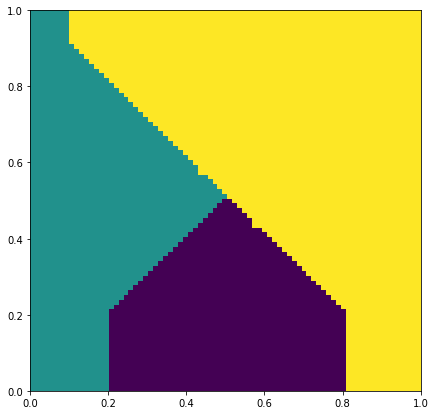

In [76]:
# Input
dirty_level = dict(DIRTY = np.array([0., 1.]),
                   MEDIUM = np.array([.7, .3]),
                   CLEAN = np.array([1., 0.]))

battery_level = dict(HIGH = np.array([.1, .9]),
                     LOW = np.array([.8, .2]))

# Output
mode = dict(CLEANING = np.array([0.0,0.0,1.0]),
            STANDBY = np.array([0.0,1.0,0.0]),
            CHARGING = np.array([1.0,0.0,0.0]))

# Fuzzify a real value into a normal fuzzy number
fuzzify = lambda x: np.array([1.0-x, x])

# Cylindrical closure (just cartesian product of features)
closure = lambda *x: np.concatenate(x)

# Fuzzy inference formular
conclusion = lambda rule, *features: np.max(np.minimum(closure(*features)[...,np.newaxis],rule), axis=0)

# Rules
whatever = np.empty(0) # Irrelevant feature placeholder
new_rule = lambda dirty, battery, mode: np.outer(closure(dirty, battery), mode) # Correlation product

Rules = [
    [ new_rule(dirty_level['DIRTY'],battery_level['HIGH'],mode['CLEANING']),
      new_rule(dirty_level['MEDIUM'],battery_level['HIGH'],mode['CLEANING'])],
    [ new_rule(whatever, battery_level['LOW'], mode['CHARGING']) ],
    [ new_rule(dirty_level['CLEAN'], whatever, mode['STANDBY']) ]
]

def fuzzy_control1(dirty, battery):
    d = fuzzify(dirty)
    b = fuzzify(battery)
    conclusions = []
    for rule in Rules[0]:
        conclusions.append(conclusion(rule,d,b))
    for rule in Rules[1]:
        conclusions.append(conclusion(rule,b))
    for rule in Rules[2]:
        conclusions.append(conclusion(rule,d))
        
    # Max aggregation
    aggregated_conclusion = np.max(conclusions, axis = 0)
    
    # Defuzzification
    return np.argmax(aggregated_conclusion)-1

def plot(fuzzy_control):
    dirty = np.linspace(0., 1., 80) 
    battery = np.linspace(0., 1., 80) 
    X, Y = np.meshgrid(dirty, battery) 
    Z = np.vectorize(fuzzy_control)(X, Y)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(X, Y, Z)
    
plot(fuzzy_control1)